# A2a Signal Detection
Ryan Lin

In [1]:
from A2a_rhl72 import *
import matplotlib.pyplot as plt


## Wave Forms
---

$$
y[t] = x[t] + \epsilon[t]
$$

- y is the wave 
- x is the events 
- epsilon is the noise


## Impulse Representation

Each event x is modeled as an impulse with a fixed amplitude **A**.

In discrete terms it could be represented as

$$
\delta [t - \tau]
$$

The full signal can be computed as 
$$
x[t] = \sum_{i=1}^{N} A * \delta [t - \tau_i]
$$

*brackets indicate discrete*

## Types of Noise

### **Gaussian Noise**
Event $\epsilon[t]$ is sampled from a normal distribution

$$
\epsilon[t] \sim \mathcal{N}(0,\sigma^2)
$$

### **Uniform Noise**
Event $\epsilon[t]$ is drawn from a uniform distribution with zero mean and a range defined by $\sigma$

$$
[-\frac{\sigma}{2}, \frac{\sigma}{2}]
$$

In [2]:
def plot_waveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian', threshold=None):

    # Generate waveform and event indices
    wave, event_indices = genwaveform(N, alpha, A, mu, sigma, noisetype)

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(wave, label=f'Waveform (Noise: {noisetype})', color='b')

    # Plot event markers (red dots)
    plt.scatter(event_indices, wave[event_indices], color='red', label="Events", marker='o')

    # Add threshold lines if specified
    if threshold is not None:
        plt.axhline(threshold, color='green', linestyle="dotted")
        plt.axhline(-threshold, color='green', linestyle="dotted")

    # Labels and title
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Generated Waveform with Amplidtude {A}")
    plt.legend()
    plt.grid()
    plt.show()


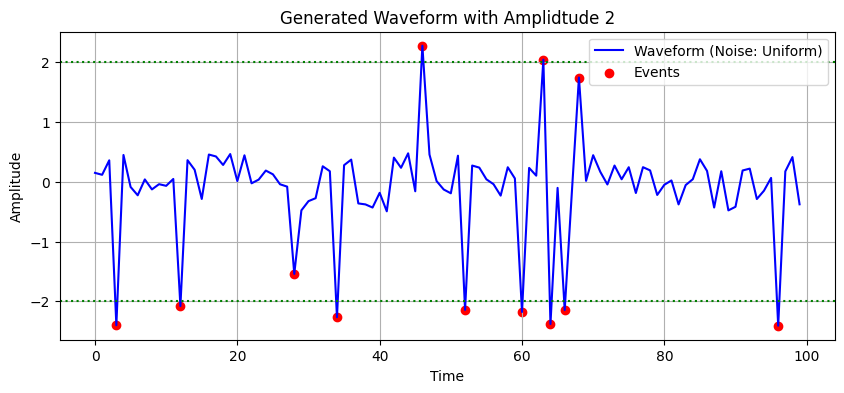

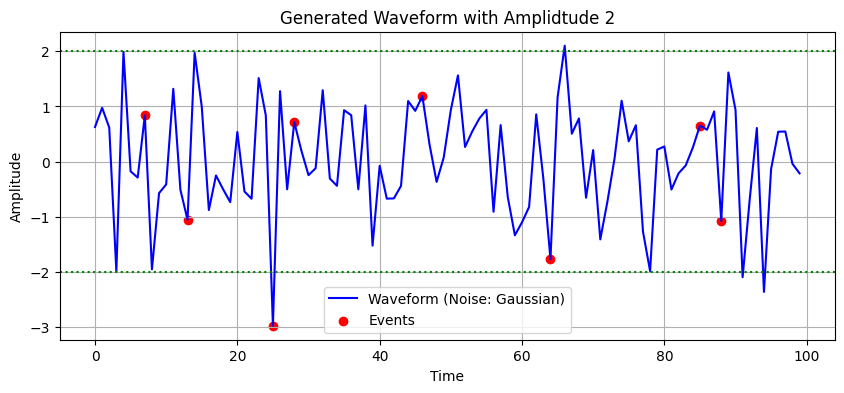

In [3]:
plot_waveform(N=100, alpha=0.1, A=2, mu=0, sigma=1, noisetype='Uniform', threshold=2)
plot_waveform(N=100, alpha=0.1, A=2, mu=0, sigma=1, noisetype='Gaussian', threshold=2)